<a id='top'></a>

# CSCI 3202: Intro to AI - Fall 2020 Practicum 2

## Your name: Andrew Pickner

#### Collaborator's name (optional): None


---
**Shortcuts:**  [Problem 1: Search](#p1) | [Problem 2: MDP](#p2) | [Problem 3: Q_Learn](#bot)

---

This practicum is due on Canvas by **10:00 PM on Saturday December 12**. Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  

**Here are the rules:** 

1. All work, code and analysis, must be your own. 
2. You may use your course notes, posted lecture slides, textbooks, in-class notebooks, and homework solutions as resources.  You may also search online for answers to general knowledge questions like the form of a probability distributions or how to perform a particular operation in Python/Pandas. 
3. This is meant to be like a coding portion of your final exam. So, the instructional team will be much less helpful than we typically are with homework. For example, we will not check answers, help debug your code, and so on.
4. If something is left open-ended, it is because we want to see how you approach the kinds of problems you will encounter in the wild, where it will not always be clear what sort of tests/methods should be applied. Feel free to ask clarifying questions though.
5. You may **NOT** post to message boards or other online resources asking for help.  If you have a question for us, post it as a **PRIVATE** message on Piazza.  If we decide that the question is appropriate for the entire class, then we will add it to a Practicum clarifications thread. 
6. You may re-use your code or code given from in-class solutions (for e.g. Astar, MDP), but you **must cite** in comments any regions of code that were not created anew for this practicum.
7. You may collaborate with **exactly one** of your classmates.  You must each submit your own assignments and write your own code, and may only collaborate on ideas, psuedocode, etc.  If you choose to collaborate with another student in the class, list their name under yours above.
8. In short, **your work must be your own**. It really is that simple.

Violation of the above rules will result in an immediate academic sanction (*at the very least*, you will receive a 0 on this practicum or an F in the course, depending on severity), and a trip to the Honor Code Council.

**By submitting this assignment, you agree to abide by the rules given above.**

***

**NOTES**: 

- You may not use late days on the practicums nor can you drop your practicum grades.
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc. 
- This should go without saying, but... For any question that asks you to calculate something, you **must show all work to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit.
***


In [1]:
import pandas as pd
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors


Consider the map of the area to the west of the Engineering Center given below, with a fairly coarse Cartesian grid superimposed.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/engineering_center_grid_zoom.png" style="width: 800px;"/>

The green square at $(x,y)=(1,15)$ is the starting location, and you would like to walk from there to the yellow square at $(25,9)$. The filled-in blue squares are obstacles, and you cannot walk through those locations.  You also cannot walk outside of this grid.

Legal moves in the North/South/East/West directions have a step cost of 1. Moves in the diagonal direction (for example, from $(1,15)$ to $(2,14)$) are allowed, but they have a step cost of $\sqrt{2}$. 


In [2]:
#Some tuples defining the wall and state locations, for your convenience

walls = [(1,y) for y in range(2,15)] + [(2,y) for y in range(3,14)] + [(3,y) for y in range(4,13)] + \
        [(4,y) for y in range(5,12)] + [(x,1) for x in range(5,24)] + [(10,y) for y in range(9,13)] + \
        [(x,y) for x in range(11,14) for y in range(9,15)] + [(14,y) for y in range(11,15)] + \
        [(x,y) for x in range(21,26) for y in range(11,17)] + \
        [(x,y) for x in [0,26] for y in range(0,18)] + [(x,y) for x in range(0,26) for y in [0,17]]
        
states = [(x,y) for x in range(1,26) for y in range(1,17)]

In [3]:
# helper function that turns a state space into a matrix
def statespace_to_matrix(states, walls):
    min_x, min_y = min(states)
    max_x, max_y = max(states)
    mat = np.ones((max_x, max_y))
    for state in states:
        if state not in walls:
            mat[(state[0] - 1), (state[1] - 1)] = 0
        else:
            mat[(state[0] - 1), (state[1] - 1)] *= -1
    return mat.T

[Back to top](#top)
<a id='p1'></a>


---
## [40 pts] Part 1:  Route-finding
In this problem, our goal is to find the path from the green to yellow squares with the **shortest total path length**.

Of course, you can probably do this problem (and likely have to some degree, in your head) without a search algorithm. But that will hopefully provide a useful "sanity check" for your answer.

#### Part A
Write a function `adjacent_states(state)`:
* takes a single argument `state`, which is a tuple representing a valid state in this state space
* returns in some form the states reachable from `state` and the step costs. How exactly you do this is up to you.

Print to the screen the output for `adjacent_states((1,15))`.

In [4]:
# Your adjacency here
def adjacent_states(state):
    min_x, min_y = min(states)
    max_x, max_y = max(states)
    x, y         = state
    l            = []
    # West
    w = (x-1, y)
    if w[0] >= min_x and w not in walls:
        l.append((w, 1))
    # East
    e = (x+1, y)
    if e[0] <= max_x and e not in walls:
        l.append((e, 1))
    # North
    n = (x, y+1)
    if n[1] <= max_y and n not in walls:
        l.append((n, 1))
    # Northwest
    nw = (x-1, y+1)
    if nw[0] >= min_x and nw[1] <= max_y and nw not in walls:
        l.append((nw, np.sqrt(2)))
    # Northeast
    ne = (x+1, y+1)
    if ne[0] <= max_x and ne[1] <= max_y and ne not in walls:
        l.append((ne, np.sqrt(2)))
    # South
    s = (x, y-1)
    if s[1] >= min_y and s not in walls:
        l.append((s, 1))
    # Southwest
    sw = (x-1, y-1)
    if sw[0] >= min_x and sw[1] >= min_y and sw not in walls:
        l.append((sw, np.sqrt(2)))
    # Southeast
    se = (x+1, y-1)
    if se[0] <= max_x and se[1] >= min_y and se not in walls:
        l.append((se, np.sqrt(2)))
    return l

In [5]:
adjacent_states((1,15))

[((2, 15), 1),
 ((1, 16), 1),
 ((2, 16), 1.4142135623730951),
 ((2, 14), 1.4142135623730951)]

#### Part B
Three candidate heuristic functions might be:
1. `heuristic_cols(state, goal)` = number of columns between the argument `state` and the `goal`
1. `heuristic_rows(state, goal)` = number of rows between the argument `state` and the `goal`
1. `heuristic_eucl(state, goal)` = Euclidean distance between the argument `state` and the `goal`

Write a function `heuristic_max(state, goal)` that returns the maximum of all three of these heuristic functions for a given `state` and `goal`.

In [6]:
#
def heuristic_cols(state, goal):
    return abs(state[0] - goal[0])
#    
def heuristic_rows(state, goal):
    return abs(state[1] - goal[1])
#    
def heuristic_eucl(state, goal):
    return np.sqrt((heuristic_cols(state, goal) ** 2) + (heuristic_rows(state, goal) ** 2))
#
def heuristic_manh(state, goal):
    return abs(heuristic_cols(state, goal)) + abs(heuristic_rows(state, goal))
#
def heuristic_max1(state, goal):
    c = heuristic_cols(state, goal)
    r = heuristic_rows(state, goal)
    e = heuristic_eucl(state, goal)
    return max(c,r,e)
#
def heuristic_max2(state, goal):
    c = heuristic_cols(state, goal)
    r = heuristic_rows(state, goal)
    m = heuristic_manh(state, goal)
    return max(c,r,m)

#### Part C
Is the Manhattan distance an admissible heuristic function for this problem?  Explain why or why not.

**Answer here**

Well, to be an admissible heuristic, one must underestimate (or equal) the *true* cost for all nodes in the graph, and it's pretty clear that the manhatten distance overestimates the true cost at some of the nodes. I run an experiment for this down below from the point SW from our goal two points.The true cost from this spot would be $2\cdot \sqrt{2}=2.8284$ rather than $4$ because we can walk diagonally.

In [7]:
print("Eucl: ", heuristic_max1((23,7), (25,9)))
print("Manh: ", heuristic_max2((23,7), (25,9)))

Eucl:  2.8284271247461903
Manh:  4


#### Part D
Use A\* search and the `heuristic_max` heuristic to find the shortest path from the initial state at $(1,15)$ to the goal state at $(25,9)$. Your search **should not** build up the entire state space graph in memory. Instead, use the `adjacent_states` function from Part A, similarly to the 8-tile problem from Homework 3. 

In [8]:
#Astar soln:
def get_distance(p1, p2):
    # just a simple reworking of the Euclidian distance/pythagorean equation
    return np.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2))

# ii
def pathcost(path):
    # init distance
    d = 0
    # iterate through a list of (x, y) points 
    for i in range(len(path) - 1):
        # use get_distance for each of the points
        d += get_distance(path[i], path[i + 1])
    # return distance
    return d

class Frontier_PQ:
    states = {}
    q_star = []
    
    def __init__(self, start, cost):
        heapq.heappush(self.q_star, (cost, start))
        self.states[start] = cost
        
    def add(self, state, cost):
        heapq.heappush(self.q_star, (cost, state))
        try:
            temp_cost = self.states[state]
        except KeyError:
            self.states[state] = cost
        else:
            self.states[state] = temp_cost if temp_cost < cost else cost
            
    def pop(self):
        return heapq.heappop(self.q_star)
    
    def replace(self, state, cost):
        if self.states[state] > cost:
            i = 0
            x = -1
            for each in self.q_star:
                if each[1] == state:
                    self.states[state] = cost
                    x = i
                    break
                i += 1
            self.q_star.pop(x)
            self.add(state, cost)
        
    # added this function to tell if a given state is in the priority queue    
    def isIn(self, state):
        return True if len([each for each in self.q_star if each[1] == state]) > 0 else False

    def cleanup(self):
        while len(self.q_star) > 0:
            heapq.heappop(self.q_star)
            
def astar_search(start, goal, adj_states, heuristic, return_cost, return_nexp):
    pq = Frontier_PQ(start, 0)
    path = []
    nexp = 0
    
    while pq:
        x = pq.pop()
        nexp += 1
        s = x[1]
        c = x[0] + heuristic(s, goal)
        # Get all adjacent vertices of the 
        # dequeued vertex s. If a adjacent 
        # has not been visited, then mark it 
        # visited and enqueue it 
        temp = []
        adjacent_states = adj_states(s)
        for state in adjacent_states: 
            temp.append((state[1] + heuristic(state[0], goal), state[0]))
        min_state = min(temp)
        if not pq.isIn(min_state[1]):
            pq.add(min_state[1], min_state[0] + c)
        
        path.append(s)

        if s == goal:
            journey = path
            pq.cleanup()
            if return_cost and return_nexp:
                return (journey, pathcost(journey), nexp)
            elif return_cost:
                return (journey, pathcost(journey))
            elif return_nexp:
                return (journey, nexp)
            else:
                return journey

In [9]:
# I tweak astar from HW2 to accept a function that returns a list of adjacent states with costs 
# (function we have to implement in part A)
# This way we build our pq more mem efficient.
astar_sol = astar_search((1,15), (25,9), adjacent_states, heuristic_max1, True, True)

astar_sol

([(1, 15),
  (2, 15),
  (3, 15),
  (4, 15),
  (5, 15),
  (6, 15),
  (7, 15),
  (8, 15),
  (9, 15),
  (10, 15),
  (11, 15),
  (12, 15),
  (13, 15),
  (14, 15),
  (15, 14),
  (16, 13),
  (17, 13),
  (18, 12),
  (19, 12),
  (20, 11),
  (21, 10),
  (22, 10),
  (23, 10),
  (24, 9),
  (25, 9)],
 26.485281374238575,
 25)

#### Part E
Make a figure depicting the optimal route from the initial state to the goal, similarly to how you depicted the maze solution in Homework 2.

In [10]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_maze(maze, path):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})
    fig.set_size_inches(18.5, 10.5)
#     cmap1 = ListedColormap(["#ff7f50", "#708090"])
    ax1.pcolormesh(maze, cmap='RdYlGn', edgecolors='k', linewidths=1)
    ax1.axis('equal')
    ax1.set_xticks([], minor=False)
    if path != None:
        temp = np.copy(maze)
        for each in path:
            temp[each[1]-1][each[0]-1] = 2
#         cmap2 = ListedColormap(["#ff7f50", "#708090", "#FFAE90"])
        ax2.pcolormesh(temp, cmap='RdYlGn', edgecolors='k', linewidths=1)
        ax2.axis('equal')
        ax2.set_xticks([], minor=False)
        ax2.set_yticks([], minor=False)

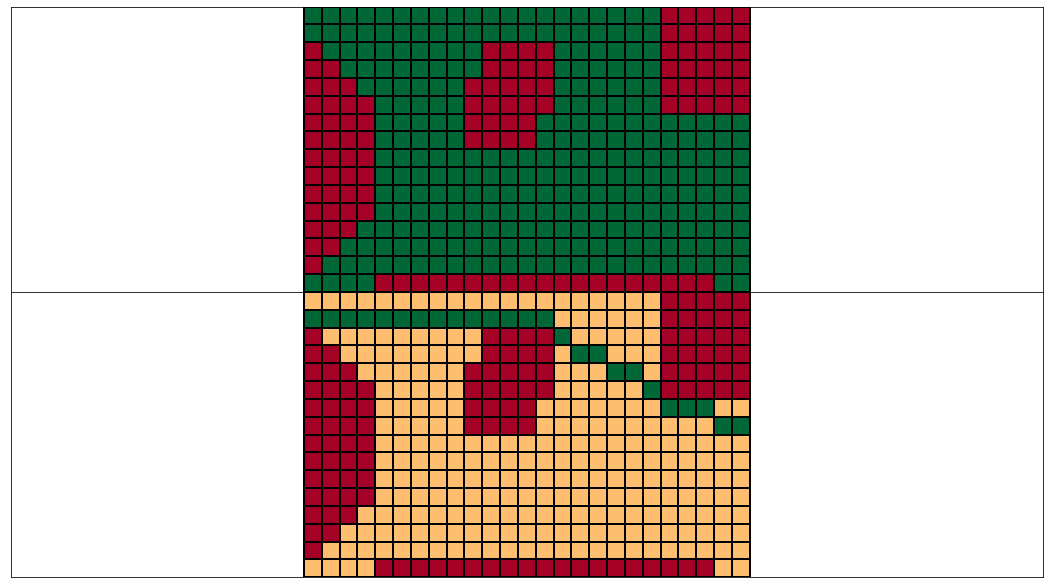

In [11]:
plot_maze(statespace_to_matrix(states, walls), astar_sol[0])

In [12]:
'''
I wanted to see how the Manhatten heuristic performed out of curiosity. 
Not quite as good, and a little strange to be honest, but not *thaat* bad. 
'''
astar_sol2 = astar_search((1,15), (25,9), adjacent_states, heuristic_max2, True, True)

astar_sol2

([(1, 15),
  (2, 14),
  (3, 13),
  (4, 12),
  (5, 11),
  (6, 10),
  (7, 9),
  (8, 9),
  (9, 9),
  (10, 8),
  (11, 8),
  (12, 8),
  (13, 8),
  (14, 9),
  (15, 9),
  (16, 9),
  (17, 9),
  (18, 9),
  (19, 9),
  (20, 9),
  (21, 9),
  (22, 9),
  (23, 9),
  (24, 9),
  (25, 9)],
 27.313708498984763,
 25)

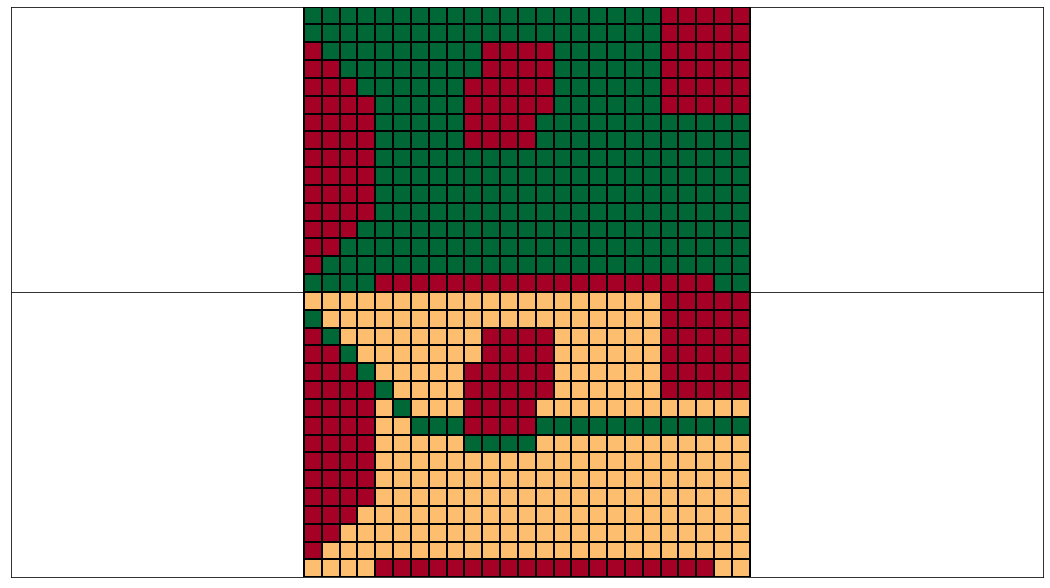

In [13]:
plot_maze(statespace_to_matrix(states, walls), astar_sol2[0])

[Back to top](#top)
<a id='p2'></a>


---
## [40 pts] Part 2:  States and Values

Winter has come, and now the area west of Engineering is icy and slippery.  As a result, there's a risk that we don't end up in the tile that we intend to move to!  In particular, if we have $k$ available actions in state $n$, the probably that we move to the state $s'$ we intend to is 75\%, and the remaining 0.25 probability is spread equally likely across all of the other adjacent (N/S/E/W/NW/NE/SE/SW) non-wall states.

In this problem, our goal is to create a policy for an agent walking in the given space west of Engineering.  Again, the goal of the agent is to navigate from start to finish, but now we want a policy for each and every location on the map.

This time, however, we're going to add the same type of randomness that our process in homework 4 had.

Because the state space is fully observable, we should be able to implement this as a Markov Decision process.


#### Part A:

Write the necessary functions to create *either* a **value iteration** or **policy iteration** scheme to solve for the MDP.  If you wish to follow the schema for homework 4, you may want to create an `MDP` class, with methods:

- `actions`, given by the valid successor states $s'$ from all actions $a$ in state $s$ in your adjacent_states from part 1.
- `rewards`, given by a significant positive reward for the goal state (e.g. 10) and a small negative reward for spending a long time in the system (e.g. non-wall reward of -0.01).
- `result`, which returns the successor state $s'$ of an *actual* movement $a$ from state $s$.
- `transition`, which returns the probability of an actual successor $s'$ given action $a$ from state $s$ using the 75\%-25% split above.


In [14]:
# Other helpers
def result_func(state, action):
    x, y = state[0], state[1]
    if "N" in action:
        y+=1
    if "S" in action:
        y-=1
    if "E" in action:
        x+=1
    if "W" in action:
        x-=1
    return x, y
result_func((2,1), "NE")

(3, 2)

In [15]:
class MDP:
    def __init__(self, states, walls, terminal, default_reward, discount, action_func):
        '''Create/store the following attributes:
        states -- list of all the states (x,y) tuples
        terminal_states -- is a dictionary with terminal state keys, and rewards as values
        default_reward -- is the reward for being in any non-terminal state
        df -- discount factor
        ... and anything else you decide will be useful!
        '''
        self.states          = [s for s in states if s not in walls]
        self.terminal_states = terminal
        self.default_reward  = default_reward
        self.df              = discount    
        self.actions_f       = action_func
        

    def actions(self, state):
        '''Return a list of available actions from the given state.
        [None] are the actions available from a terminal state.
        '''
        if state in self.terminal_states:
            return [None]
        x, y = state[0], state[1]
        new_states = self.actions_f(state)
        l = []
        for s in new_states:
            new_x, new_y = s[0][0], s[0][1]
            action_s = ""
            if new_y == (y+1):
                action_s += "N"
            if new_y == (y-1):
                action_s += "S"
            if new_x == (x+1):
                action_s += "E"
            if new_x == (x-1):
                action_s += "W"
            l.append(action_s)
        return l
        
    def reward(self, state):
        '''Return the reward for being in the given state'''
        return self.terminal_states[state] if state in self.terminal_states else self.default_reward
        
        
    def results(self, state, action):
        '''Return the resulting state (as a tuple) from doing the given
        action in the given state, without uncertainty. Uncertainty
        is incorporated into the transition method.
        state -- a tuple representing the current state
        action -- one of N, S, E or W, as a string
        '''
        if action == None:
            return state
        assert action in self.actions(state), 'Error: action needs to be available in that state'
        assert state in self.states, 'Error: invalid state'
        #your code goes here...
        x, y = state[0], state[1]
        if "N" in action:
            y+=1
        if "S" in action:
            y-=1
        if "E" in action:
            x+=1
        if "W" in action:
            x-=1
        return x, y        
        
                
    def transition(self, state, action):
        '''Return the probabilities and subsequent states associated
        with taking the given action from the given state. Can be done
        however you want, so that it works with your value/policy iteration.
        '''
        if action is None:
            return [(0, state)]
        else:
            l = []
            # your code goes here...
            poss_moves = self.actions(state)
            poss_moves.append(None)
            for move in poss_moves:
                new_state = self.results(state, move)
                if move == action:
                    l.append((0.75, new_state))
                else: 
                    l.append((0.25 / (len(poss_moves) - 1), new_state))
            return l


#### Part B:

Using the MDP in part 2A, implement value iteration **or** policy iteration to calculate the utilities for each state. Also implement a function that takes as arguments an MDP object and a dictionary of state-utility pairs (key-value) and returns a dictionary for the optimal policy. The optimal policy dictionary should have state tuples as keys and the optimal move (None or any of the 8 directions) as values.

In [16]:
def value_iteration(mdp, tol=1e-3, max_depth=100_000):
    # your code goes here...
    #NB: we did value iteration in the in-class notebook!
    # initilize utility for all states
    i = 0
    df = mdp.df

    utility_new = {s : 0 for s in mdp.states}

    # iterate:
    while True:
        # make a copy of current utility estimate, to be modified
        utility_old = utility_new.copy()
        # initialize maximum change to 0
        max_change = 0

        for s in mdp.states:
            utility_old[s] = utility_new[s]
            # for each available action, what next states
            # are possible, and their probabilities?
            next_states = [mdp.transition(s, a) for a in mdp.actions(s)]
            # calculate the maximum expected utility
            best_utility = -np.inf
            newsums = []
            for k in range(len(next_states)):
                newsums.append(sum([next_states[k][j][0]*utility_old[next_states[k][j][1]] for j in range(len(next_states[k]))]))
            best_utility = max(newsums)
#             i+=1
            if i > max_depth:
                return utility_new
            # new utility of s = reward(s) + 
            #                    discounted max expected utility
            utility_new[s] = mdp.reward(s) + df*best_utility
            # update maximum change in utilities, if needed
            max_change = max(max_change, abs(utility_new[s]-utility_old[s]))
        # if maximum change in utility from one iteration to the
        # next is less than some tolerance, break!
        if (df==1 and max_change < tol) or max_change < tol*(1-df)/df:
            break
    return utility_new

def policy_iteration(mdp, utility):
    
    # your code goes here...
    # initialize the policy for each state
    policy = {s : None for s in mdp.states}

    # loop over states to find the action that maximizes expected utility
    for s in mdp.states:

        # initialize the best utility to something very bad, so we can improve it
        best_utility = (-999, None)

        # loop over actions, find which gives the highest expected utility
        for a in mdp.actions(s):
            # calculate the expected utility of action a from state s
            newsum = sum([p*utility[s2] for p, s2 in mdp.transition(s,a)])
            # if this action has higher expected utility than the current best,
            # replace the best (utility, action) tuple with this one
            if newsum > best_utility[0]:
                best_utility = (newsum, a)
        # now we have the action (second element) that leads
        # to the highest expected utility (first element)
        policy[s] = best_utility[1]

    # upon exit, policy has the optimal policy for each state
    return policy

In [17]:
terminal_state = {(25,9): 1}

default_reward = -0.01
discount       = 0.99

mdp = MDP(states, walls, terminal_state, default_reward, discount, adjacent_states)

In [18]:
adjacent_states((1, 1))

[((2, 1), 1), ((2, 2), 1.4142135623730951)]

In [19]:
mdp.actions((1,1))

['E', 'NE']

In [20]:
mdp.transition((1,1), 'NE')

[(0.125, (2, 1)), (0.75, (2, 2)), (0.125, (1, 1))]

In [21]:
mdp.results((1,1), 'NE')

(2, 2)

---
[This paper](https://papers.nips.cc/paper/2008/file/08c5433a60135c32e34f46a71175850c-Paper.pdf) was  helpful with making me alright with my discount factor. Modelling this entire solution on HW4, I was getting really weird utilities. Specifically, my utilities for states were becoming much larger than the reward for the terminal state which felt really wrong. Ultimately this assignment made me feel incredibly dumb because it literally felt like HW4, but I couldn't get any of my code to work.

---

In [22]:
utility = value_iteration(mdp)

utility

{(1, 1): 0.44200776087935145,
 (1, 15): 0.43845363151109357,
 (1, 16): 0.4344873215390762,
 (2, 1): 0.4561287386904992,
 (2, 2): 0.45908012248545904,
 (2, 14): 0.4562506849143935,
 (2, 15): 0.4518735758564416,
 (2, 16): 0.4479874604088547,
 (3, 1): 0.47246251084311564,
 (3, 2): 0.4753129318648307,
 (3, 3): 0.4780945870900443,
 (3, 13): 0.4755791508434592,
 (3, 14): 0.4714434506195482,
 (3, 15): 0.46755208772354545,
 (3, 16): 0.4662675913953971,
 (4, 1): 0.49041822916874667,
 (4, 2): 0.4928898343841187,
 (4, 3): 0.4953178671134766,
 (4, 4): 0.497321729727893,
 (4, 12): 0.4951633372244756,
 (4, 13): 0.4914078166249005,
 (4, 14): 0.4875781115915894,
 (4, 15): 0.4867921268585815,
 (4, 16): 0.4860564000815741,
 (5, 2): 0.5130416428714144,
 (5, 3): 0.5145539748016682,
 (5, 4): 0.5154907989638863,
 (5, 5): 0.5165438689289611,
 (5, 6): 0.5178130191484916,
 (5, 7): 0.517882339977805,
 (5, 8): 0.5178657456526071,
 (5, 9): 0.5177456190880849,
 (5, 10): 0.5172344645081811,
 (5, 11): 0.514911882180

In [23]:
policy = policy_iteration(mdp, utility)

policy

{(1, 1): 'NE',
 (1, 15): 'SE',
 (1, 16): 'SE',
 (2, 1): 'NE',
 (2, 2): 'NE',
 (2, 14): 'SE',
 (2, 15): 'SE',
 (2, 16): 'SE',
 (3, 1): 'NE',
 (3, 2): 'NE',
 (3, 3): 'NE',
 (3, 13): 'SE',
 (3, 14): 'SE',
 (3, 15): 'SE',
 (3, 16): 'SE',
 (4, 1): 'NE',
 (4, 2): 'NE',
 (4, 3): 'NE',
 (4, 4): 'NE',
 (4, 12): 'SE',
 (4, 13): 'SE',
 (4, 14): 'SE',
 (4, 15): 'SE',
 (4, 16): 'SE',
 (5, 2): 'NE',
 (5, 3): 'NE',
 (5, 4): 'NE',
 (5, 5): 'NE',
 (5, 6): 'NE',
 (5, 7): 'E',
 (5, 8): 'SE',
 (5, 9): 'SE',
 (5, 10): 'SE',
 (5, 11): 'SE',
 (5, 12): 'SE',
 (5, 13): 'SE',
 (5, 14): 'SE',
 (5, 15): 'SE',
 (5, 16): 'SE',
 (6, 2): 'NE',
 (6, 3): 'NE',
 (6, 4): 'NE',
 (6, 5): 'NE',
 (6, 6): 'E',
 (6, 7): 'SE',
 (6, 8): 'SE',
 (6, 9): 'SE',
 (6, 10): 'SE',
 (6, 11): 'SE',
 (6, 12): 'SE',
 (6, 13): 'NE',
 (6, 14): 'NE',
 (6, 15): 'E',
 (6, 16): 'SE',
 (7, 2): 'NE',
 (7, 3): 'NE',
 (7, 4): 'NE',
 (7, 5): 'NE',
 (7, 6): 'E',
 (7, 7): 'SE',
 (7, 8): 'SE',
 (7, 9): 'SE',
 (7, 10): 'SE',
 (7, 11): 'SE',
 (7, 12): 'NE'


#### Part C:

Sanity check your answers in part B by listing which state has the *lowest* estimated utility (should be far from the goal!) and which states have the 3 *highest* estimated utilities.

In [24]:
min_util = min(utility.values())
min_res = [key for key in utility if utility[key] == min_util] 

print("Minimum utility and state: ", min_util, min_res[0])

Minimum utility and state:  0.4344873215390762 (1, 16)


In [25]:
three_max = heapq.nlargest(3, utility, key = utility.get) 
for max_val in three_max: 
    print("Maximum utility and state: ", max_val, utility.get(max_val))

Maximum utility and state:  (25, 9) 1.0
Maximum utility and state:  (25, 10) 0.9728035523516534
Maximum utility and state:  (24, 9) 0.9699921535416248



#### Part D:

As in part 1E, make a figure.  This time, depict the optimal policy at each location.  Your choice of visualization is up to you, but I would *recommend* taking a plot similar to the maze plot in Part 1E above (or HW 2) and plotting some choice of arrows/symbols/colors corresponding to the appropriate action in each square.

In [26]:
def visualizePolicies(state_matrix, utility, policy):
    fig, ax = plt.subplots()

    for s in utility:
        state_matrix[s[1]-1, s[0]-1] = utility[s[0], s[1]]
    ax.pcolormesh(state_matrix, cmap='RdYlGn', edgecolors='k', linewidths=1)
    for p in policy:
        pol = policy[p]
        if pol != None:
            text = ax.text(p[0]-0.44, p[1]-0.5, '{:^3}'.format(pol), ha='center', va='center', color="w")
        else:
            text = ax.text(p[0]-0.44, p[1]-0.5, '{:^3}'.format("X"), ha='center', va='center', color="w")
    plt.show()

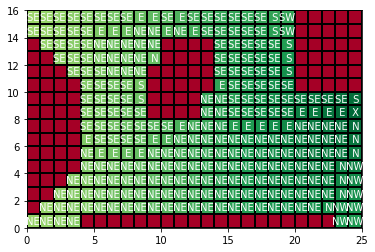

In [27]:
visualizePolicies(statespace_to_matrix(states, walls), utility, policy)

---
[This was a cool article.](https://www.datascienceblog.net/post/reinforcement-learning/mdps_dynamic_programming/) I  finally got it after a lot of time, finding a particularly interestingly devastating bug (my actions function wasn't returning the option for SW), and some help from this resource!

---

[Back to top](#top)
<a id='p3'></a>


---
## [20 pts] Part 3:  The great unknown

It's nearly winter solstice, and the area west of Engineering is still icy and slippery.  

As a result, there's still a risk that we don't end up in the tile that we intend to move to!  Unfortunately, for this problem we *don't know* what that risk is, and it isn't the same everywhere.  As in Problem 2, our goal is to create a policy for an agent walking in the given space west of Engineering.  Again, the goal of the agent is to navigate from start to finish, but now we want a policy for each and every location on the map

Suppose there exists some function $f$ that measures the *footing* of state $s$.  Then if we choose to take the action "move towards state $s'$" from state $n$, the probability that we *actually arrive* in the state $s'$ we intend to is $f(s)$.  As before, the remaining $1-f(s)$ probability is spread equally likely across all of the other adjacent (N/S/E/W/NW/NE/SE/SW) non-wall states to $s$.

Because our agent can't fully observe the transitions, it's going to have to pick actions and estimate their utilities from learning.  Let's use Q-learning!

#### Part A:

Run the following code to provide a function for and a map of the footing function $f$.



Text(0.5, 1.0, 'Footing')

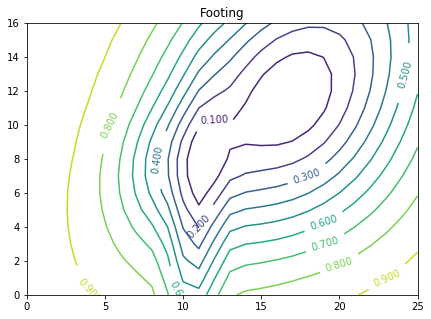

In [28]:
###YOU MAY IGNORE THIS CELL, BUT MUST RUN IT TO GENERATE F
random.seed(30)
x = np.linspace(0,25,26)
y = np.linspace(0,25,26)
X,Y = np.meshgrid(x,y)
f1 = np.zeros(X.shape)
f2 = np.zeros(X.shape)
f3 = np.zeros(X.shape)
f4 = np.zeros(X.shape)

mu1, mu2, mu3, mu4=[17,12],[17,11],[11,8],[11,6]
covar1, covar2, covar3, covar4= [[16,8],[8,16]],[[12,.5],[.5,12]],[[4,.8],[.8,4]],[[.8,12],[.8,12]]
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        f1[i,j] = 6*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu1, cov=covar1)
        f2[i,j] = 3*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu2, cov=covar2)
        f3[i,j] = stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu3, cov=covar3)
        f4[i,j] = 1*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu4, cov=covar4)
        
f =f1+f2+f3+f4    
f=1-(f/np.max(f))**(1/3)

#PLOTTING:
fig, ax = plt.subplots(1,1, figsize=(7,5))
my_levels = np.linspace(0, 1, 11)
labels = [str(lv) for lv in my_levels]
cp = ax.contour(X, Y, f, levels=my_levels)
plt.clabel(cp, inline=1, fontsize=10)
ax.set(xlim=(0, 25), ylim=(0, 16))
plt.title('Footing')

In [29]:
# You can access f directly using indices if you use the TRANPOSE of the coordinates of each point
#which this footing function does
def footing(x,y):
    return f[y,x]

print("It's icy at (12,8), with almost no footing:", footing(12,8))
print("It's better at (8,12):", footing(8,12))

It's icy at (12,8), with almost no footing: 0.0344326686812465
It's better at (8,12): 0.6595232752211774


#### Part B:

We're going to implement Q-learning instead of an MDP.

You will probably want to create a dictionary of the form discussed at the end of the in-class notebook for Q-learning, where each valid tuple is the first key and each valid move from that location is the second key.  You then should have the estimated utilities of each action saved in the resulting dictionary.  You may include other information if desired, but nothing else should be absolutely necessary.

After initialization, print the elements of the dictionary corresponding to the (4,4) location.  Note that there should be 7 subdictionaries for the 6 possible neighbors and the `None` action, and within each action the initial Q-value should be zero.

In [30]:
#create a Q, initialize all the Q-utilities as 0.
def create_q(states, adjacent_states, no_movement=True):
    d = {}
    for s in states:
        d_0 = {}
        adj_states = adjacent_states(s)
        for adj_s in adj_states:
            d_0[adj_s] = 0
        d_0[None] = 0
        d[s] = d_0
    return d

In [31]:
adjacent_states((4,4))

[((5, 4), 1),
 ((5, 5), 1.4142135623730951),
 ((4, 3), 1),
 ((3, 3), 1.4142135623730951),
 ((5, 3), 1.4142135623730951)]

In [32]:
Q = create_q(mdp.states, adjacent_states)

Q[(4,4)]

{((5, 4), 1): 0,
 ((5, 5), 1.4142135623730951): 0,
 ((4, 3), 1): 0,
 ((3, 3), 1.4142135623730951): 0,
 ((5, 3), 1.4142135623730951): 0,
 None: 0}

#### Part C:

Use the given `footing` function to modify your `transitions` from the MDP so the probabilities of result given action now flow from the icy model above.

Perform at least 1000 training epochs, where each starts at a *random* location from the valid states (this can help if find the goal state faster!).

For each epoch, take *at most* 100 actions, or until the goal is reached.  You may choose these actions by any schema you desire, but I recommend the $\varepsilon$-greedy agent that chooses the "best available" action 80% of the time and explores the other 20%. 

Show graphs depicting the actual paths taken for the last 2 of the training epochs.

In [37]:
goal = (25, 9)

training_episodes = 1000

max_actions = 100

epsilon = 0.20

trials = 2

for i in range(training_episodes):
    num_actions = 0
#     current_state = random_state()
#     while num_actions < max_actions and current_state != goal_state:
#         greedy_choice = np.choice([True, False], p=[epsilon, 1-epsilon])
#         if greedy_choice:
#             #     current_state = random_choice()
#             pass
#         else:
#             #     current_state = best_choice()
#             pass

#### Part D:

As in part 2D, make a figure depicting the optimal policy at each location.  Does your agent actually try to avoid the ice, compared to how it behaved in the MDP in Part 2?